In [1]:
import logging
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (
        train_test_split,
        cross_validate,
        cross_val_predict,
        GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    PowerTransformer,
    LabelEncoder,
    MinMaxScaler
)
from sklearn.ensemble import(
    RandomForestClassifier
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import(
    accuracy_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    DetCurveDisplay,
    matthews_corrcoef
)
from sklearn.inspection import permutation_importance
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
df_raw = pd.read_csv('../data/Maternal Health Risk Data Set.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [3]:
df_raw.sample(10, random_state=2025)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
109,32,140,100,7.9,98.0,78,high risk
185,55,100,65,6.1,98.0,66,low risk
402,35,100,70,7.8,98.0,60,low risk
800,32,120,80,6.8,98.0,70,mid risk
684,32,140,100,6.9,98.0,78,high risk
555,50,130,100,16.0,98.0,75,mid risk
34,21,75,50,6.1,98.0,70,low risk
689,40,160,100,19.0,98.0,77,high risk
172,20,100,90,7.1,98.0,88,low risk
528,15,78,49,7.5,98.0,77,low risk


Observamos un dataset bastante completo, no hay informacion nula, todas las variables son númericas, tenemos la variable objetivo con 3 categorias. 
En la siguiente tabla vemos el diccionario de las variables

#### **Data Dictionary**
|Name|Description|Type|Units|
|----|-----------|----|-----|
|Age|Any ages in years when a women during pregnant.|Int|None|
|SystolicBP|Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.|Int|None|
|DiastolicBP|Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.|Int|None|
|BS|Blood glucose levels is in terms of a molar concentration|float|nmol/L|
|BodyTemp| |float|F|
|HeartRate|A normal resting heart rate|Int|bpm|
|RiskLevel|Predicted Risk Intensity Level during pregnancy considering the previous attribute.|Cat|None|

2. Data preprocessing
Objectives: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [4]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.lower()
df_baking['risklevel'] = df_baking['risklevel'].astype('category')
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          1014 non-null   int64   
 1   systolicbp   1014 non-null   int64   
 2   diastolicbp  1014 non-null   int64   
 3   bs           1014 non-null   float64 
 4   bodytemp     1014 non-null   float64 
 5   heartrate    1014 non-null   int64   
 6   risklevel    1014 non-null   category
dtypes: category(1), float64(2), int64(4)
memory usage: 48.8 KB


In [5]:
df.sample(10, random_state=2025)

,age,systolicbp,diastolicbp,bs,bodytemp,heartrate,risklevel
109,32,140,100,7.9,98.0,78,high risk
185,55,100,65,6.1,98.0,66,low risk
402,35,100,70,7.8,98.0,60,low risk
800,32,120,80,6.8,98.0,70,mid risk
684,32,140,100,6.9,98.0,78,high risk
555,50,130,100,16.0,98.0,75,mid risk
34,21,75,50,6.1,98.0,70,low risk
689,40,160,100,19.0,98.0,77,high risk
172,20,100,90,7.1,98.0,88,low risk
528,15,78,49,7.5,98.0,77,low risk


### **3. Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [6]:
df_train,df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=2025,
    stratify=df["risklevel"]
)
df_train,df_val = train_test_split(
    df_train,
    test_size=0.2,
    random_state=2025,
    stratify=df_train['risklevel']
)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 648 entries, 201 to 883
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          648 non-null    int64   
 1   systolicbp   648 non-null    int64   
 2   diastolicbp  648 non-null    int64   
 3   bs           648 non-null    float64 
 4   bodytemp     648 non-null    float64 
 5   heartrate    648 non-null    int64   
 6   risklevel    648 non-null    category
dtypes: category(1), float64(2), int64(4)
memory usage: 36.2 KB


In [7]:
display(df_train.describe(include='category').T)
display(df_train.describe().T)

,count,unique,top,freq
risklevel,648,3,low risk,260


,count,mean,std,min,25%,50%,75%,max
age,648.0,29.859568,13.590740,10.0,19.0,25.0,37.00,66.0
systolicbp,648.0,112.958333,18.548482,70.0,98.0,120.0,120.00,160.0
diastolicbp,648.0,76.179012,13.723322,49.0,65.0,80.0,89.25,100.0
bs,648.0,8.773657,3.313049,6.0,6.9,7.5,8.00,19.0
bodytemp,648.0,98.670370,1.381301,98.0,98.0,98.0,98.00,103.0
heartrate,648.0,74.131173,7.968044,7.0,70.0,76.0,80.00,90.0


En el análisis descriptivo observamos que la variable objetivo 'risklevel', representa con un 40% de la base de entrenamiento la clase mayoritaria, en las variables númericas se puede decir lo siguiente, en 'age' la media y la mediana difieren un poco, lo que nos puede decir que existe un pequeño sesgo positivo, esto nos indica que los valores mas grandes estan influyendo en la media; similar pasa con 'systolicbp' que su media y mediana esta un poco separadas, indicanos sesgo positivo, se puede decir que la diferencia entre el minimo y el primer cuartil, es muy baja comparada con la diferencia entre el tercer cuartil y el maximo. En 'diastolicbp' la media y la mediana tambien una separacion pequeña, ya veremos en los graficos siguientes el comportamiento, que debe ser similar a las anteriores variables; en 'bs' podemos ver que la diferencia entre el Q3 y el max es bastante, observaremos una cola en el grafico; con 'bodytemp' podemos ver que el valor se repite en todas las estadísticas menos en el max que es donde cambia, posiblemente esta variable sea una 'near zero variance', que no es adecuada agregarla en el modelo por lo que veremos si la eliminamos. En 'heartrate' vemos que entre el min y el Q1 es grande por lo que su grafico nos va a indicar una cola.

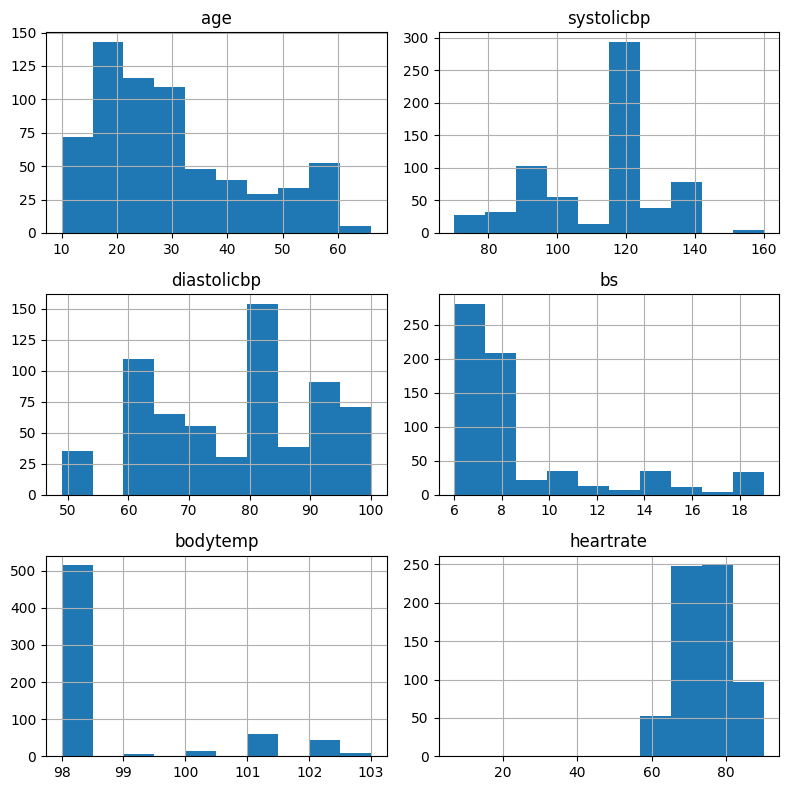

In [8]:
# Analisis univariado
df_train.hist(figsize=(8,8))
plt.tight_layout()
plt.show()

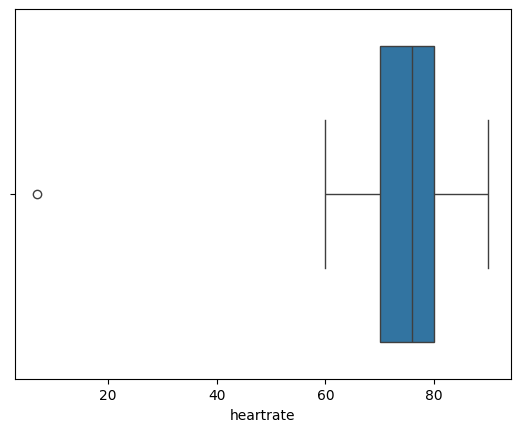

In [9]:
# como se observa que income parecen haber unos valores atipicos, vamos a revisarlo con este grafico
sns.boxplot(data=df_train, x='heartrate')
plt.show()

In [10]:
Q1 = df_train['heartrate'].quantile(0.25)  # Primer cuartil
Q3 = df_train['heartrate'].quantile(0.75)  # Tercer cuartil
IQR = Q3 - Q1                     # Rango intercuartílico

# Limites para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_train[(df_train['heartrate'] < lower_bound) | (df_train['heartrate'] > upper_bound)]
print(outliers)

     age  systolicbp  diastolicbp   bs  bodytemp  heartrate risklevel
908   16         120           75  7.9      98.0          7  low risk


In [11]:
df_train = df_train[(df_train['heartrate'] >= lower_bound)]

En los graficos, observamos que las variables presentan distribuciones concentradas en algunas barras, y describe lo que dijimos arriba, en bs vemos una la concentracion en los primeros valores y una cola derecha, lo contrario de la variable heartrate, que esta concentrado en los valores a la izquierda y con 'bodytemp' lo que observo es que mas o menos el 80% esta acumulado en el valor 98, lo que podriamos hacer es una variable binaria que nos diga temperatura 'igual a 98' si o no.

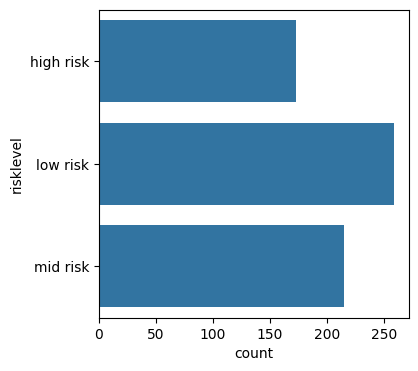

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.countplot(data=df_train, y='risklevel', ax=ax) 
plt.show()

En la variable objetivo se ve que la categoria predominante es 'low risk' como ya vimos en el analisis descriptivo, seguido por 'mid risk' y con menos porcentaje 'high risk'.

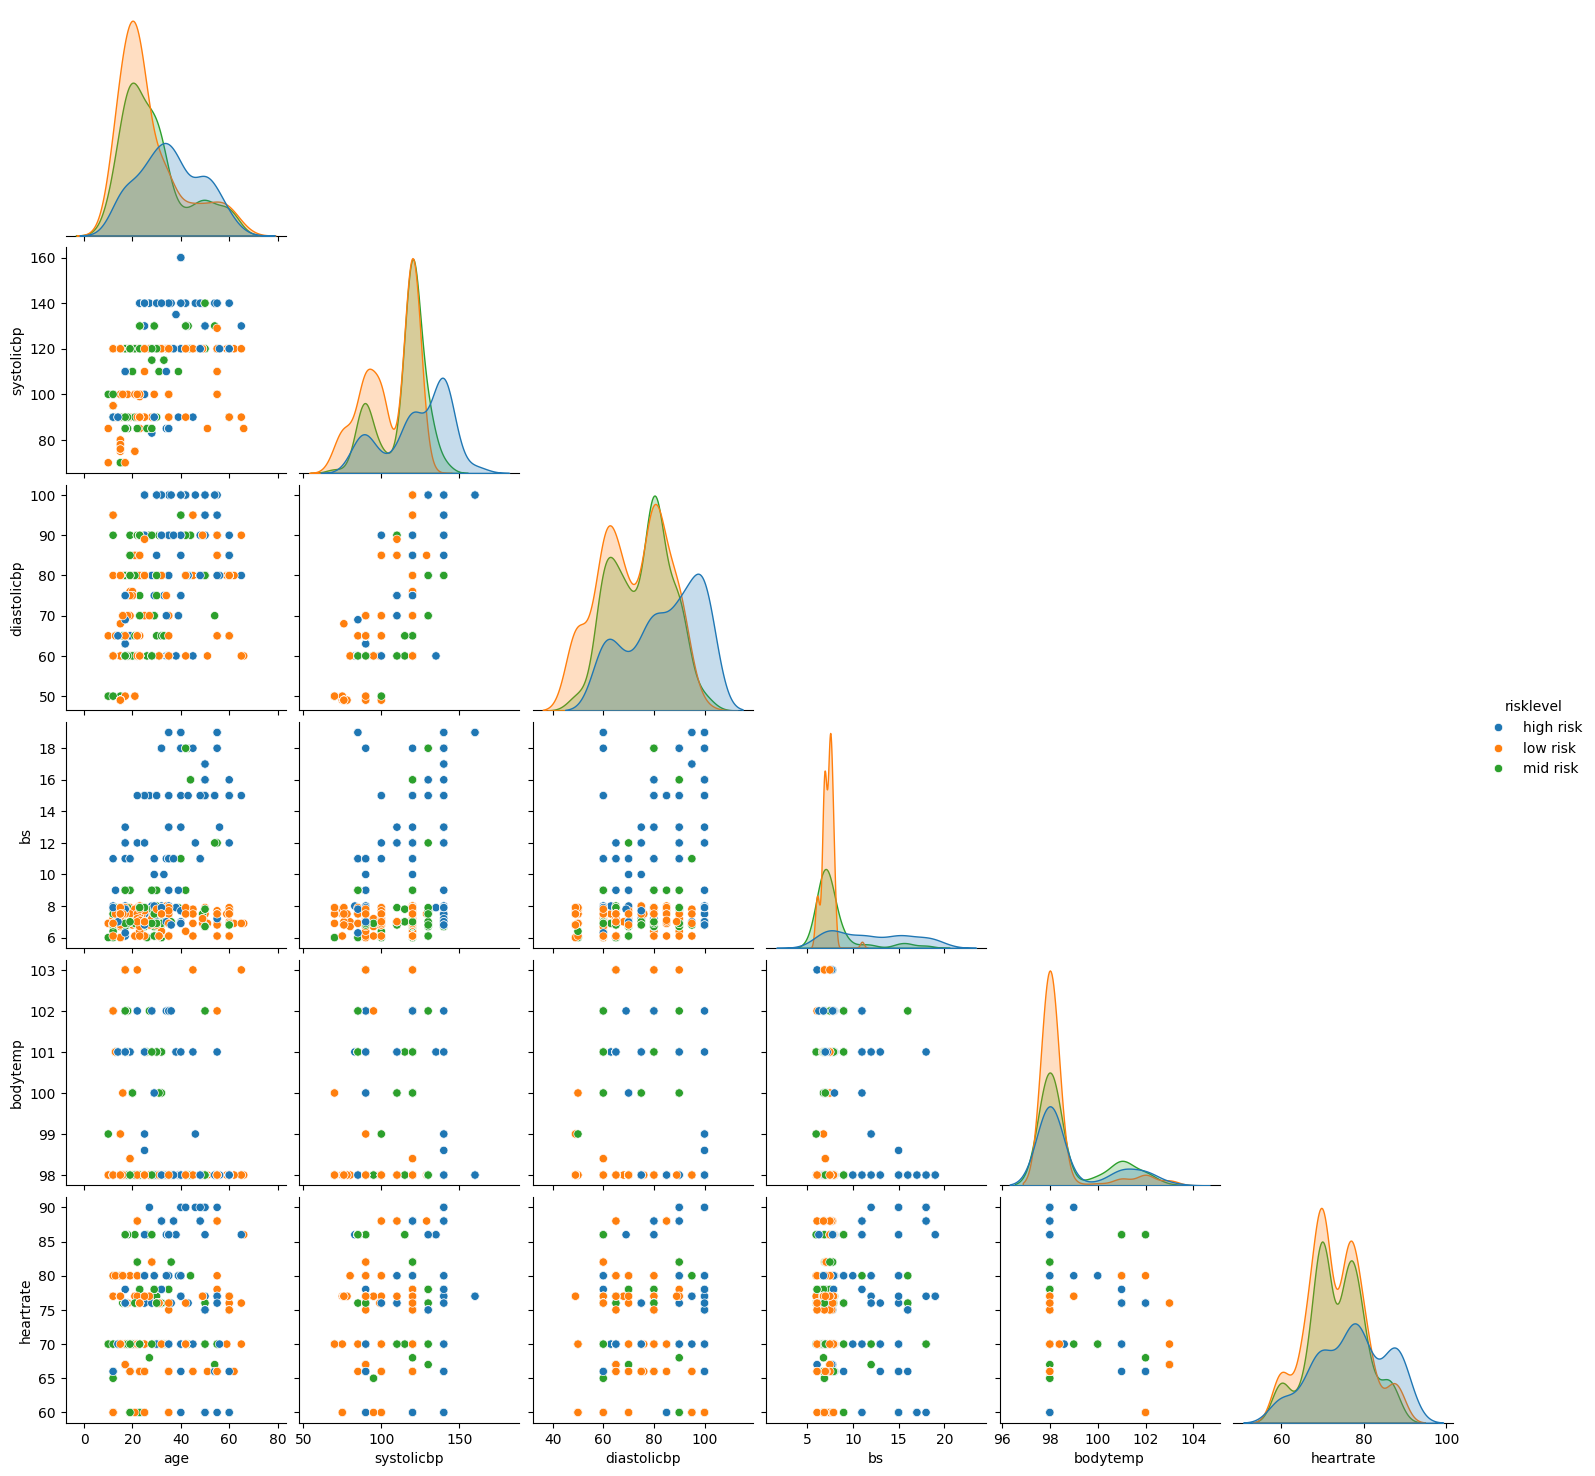

In [13]:
sns.pairplot(data=df_train, hue='risklevel', corner=True)
plt.show()

En el pairplot, en los gráficos de dispersión, no observo ningun patron aparente, veo por ejemplo algo que me llamo la atencion, cuando 'bodytemp' es alta podemos hacer un corte transversal en las variables 'age', 'systolicbp', 'diastolicbp', y podemos decir que los puntos que caen allí, tienen 'low risk'.
Las variables que separan un poco en los graficos de la diagonal son 'age', 'systolicbp', 'diastolicbp', 'heartrate'

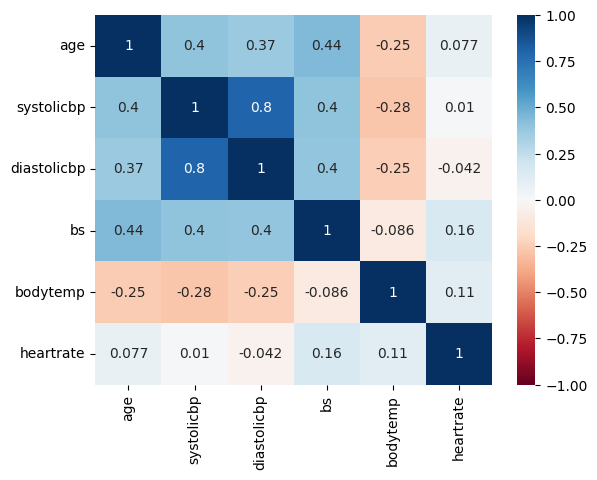

In [14]:
sns.heatmap(data=df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

En la matriz de correlación, se puede ver en 'systolicbp', 'diastolicbp' una correlación alta, como era de esperarse.

### 4. Machine learning
Objective: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

#### Random forest

In [15]:
X_train = df_train.drop(columns=["risklevel"])
y_train = df_train['risklevel'].copy()
X_val = df_val.drop(columns=["risklevel"])
y_val = df_val['risklevel'].copy()
X_test = df_test.drop(columns=["risklevel"])
y_test = df_test['risklevel'].copy()

In [16]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

In [17]:
clf_rforest_p = Pipeline([
    ("powertransform", PowerTransformer()),
    ("rforest", RandomForestClassifier(random_state=2025)),
])
clf_rforest_cv = GridSearchCV(
    clf_rforest_p,
    param_grid={
        "rforest__max_depth": [3,5,7,9],
        "rforest__n_estimators": [20,30,50,100],
        },
    cv=5,
    n_jobs = -1 # usa todos los trabajadores que puedas
)

In [18]:
clf_rforest_cv.fit(X_train, y_train_enc)
clf_rforest_cv.best_params_

{'rforest__max_depth': 9, 'rforest__n_estimators': 100}

accuracy: 82.82
Matthews Correlation Coefficient: 73.93
              precision    recall  f1-score   support

   high risk       0.93      0.91      0.92        44
    low risk       0.79      0.86      0.82        65
    mid risk       0.80      0.72      0.76        54

    accuracy                           0.83       163
   macro avg       0.84      0.83      0.83       163
weighted avg       0.83      0.83      0.83       163



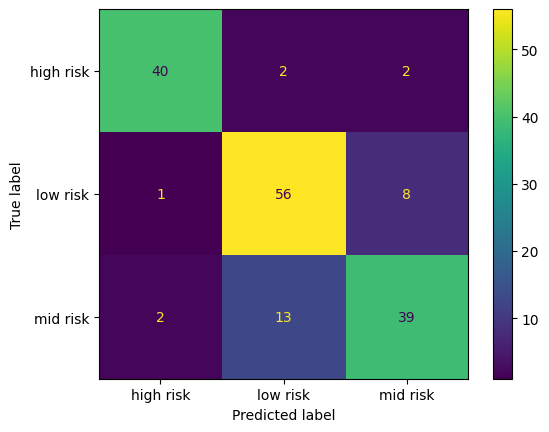

In [19]:
y_hat_val = clf_rforest_cv.predict(X_val)
print(f'accuracy: {accuracy_score(y_val_enc,y_hat_val)*100:.2f}')
print(f'Matthews Correlation Coefficient: {matthews_corrcoef(y_val_enc,y_hat_val)*100:.2f}')
print(classification_report(y_val_enc,y_hat_val,target_names = label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_val_enc, y_hat_val, display_labels= label_encoder.classes_)
plt.show()

En estas metricas podemos observar que el recall esta clasificando bastante bien los positivos en cada segmento. Adicionalmente con la metrica del coeficiente 'Matthews Correlation Coefficient' es muy buena esta por encima de una prediccion por encima del azar.

accuracy: 83.74
Matthews Correlation Coefficient: 75.61
              precision    recall  f1-score   support

   high risk       0.93      0.95      0.94        55
    low risk       0.80      0.91      0.85        81
    mid risk       0.81      0.66      0.73        67

    accuracy                           0.84       203
   macro avg       0.85      0.84      0.84       203
weighted avg       0.84      0.84      0.83       203



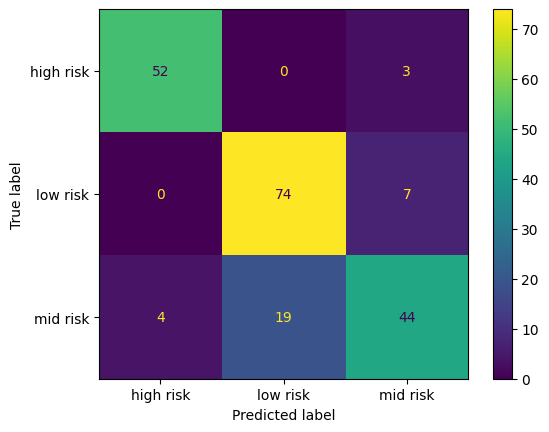

In [20]:
y_hat_test = clf_rforest_cv.predict(X_test)
print(f'accuracy: {accuracy_score(y_test_enc,y_hat_test)*100:.2f}')
print(f'Matthews Correlation Coefficient: {matthews_corrcoef(y_test_enc,y_hat_test)*100:.2f}')
print(classification_report(y_test_enc,y_hat_test,target_names = label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_hat_test, display_labels= label_encoder.classes_)
plt.show()

Podemos decir que las metricas son bastantes estables, porque tanto en validacion como en test son similares

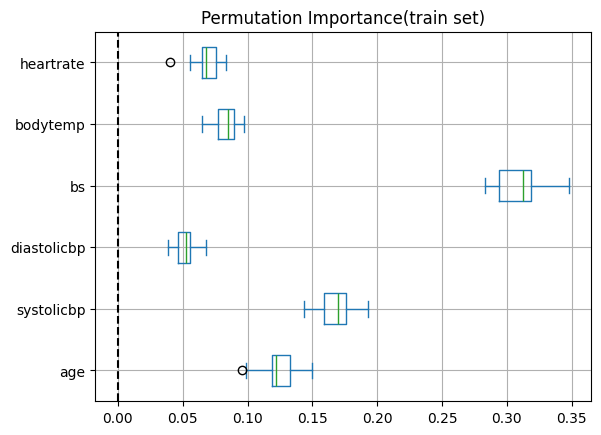

In [21]:
importance = permutation_importance(clf_rforest_cv,X_train,y_train_enc,n_repeats=25,random_state=2025)
importance_df = pd.DataFrame(importance.importances.T,columns=X_train.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0,color="k",linestyle="--")
ax.set_title("Permutation Importance(train set)")
ax.grid(True)
plt.show()

En el grafico de importancia de las variables, observo que la mejor variable sorprendentemente es 'bs', seguido por 'systolicbp', 'age', 'bodytemp'

Luego de realizar los tres algoritmos puedo decir, que con los mejores parametros que encontre hasta el momento de finalizar la sesion fue el de random forest

In [22]:
with open("../app/models/mhr_rforest_model.pkl", "wb") as maternal_h_r_rforest:
    pickle.dump(clf_rforest_cv, maternal_h_r_rforest)